In [1]:
import logging
import os
import random
from collections import Counter
from importlib import reload


import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

/Users/erikstorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
# pollock.models.model.set_training_devices(['/device:XLA_GPU:0'])

In [ ]:
# from importlib import reload
# reload(pollock)
# reload(pollock.models.model)

In [6]:
from tensorflow.python.client import device_lib
import tensorflow as tf
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11221452825783706336]

In [7]:
# tf.config.list_physical_devices('XLA_GPU')

In [8]:
# tf.keras.backend.clear_session()
# tf.config.optimizer.set_jit(True)

In [9]:
# mirrored_strategy = tf.distribute.MirroredStrategy(
#     devices=["/device:XLA_GPU:0"])

## load in expression table and labels

In [6]:
expression_fp = '/home/estorrs/data/single_cell_classification/Intra-dataset/Zheng 68K/Filtered_68K_PBMC_data.csv'
label_fp = '/home/estorrs/data/single_cell_classification/Intra-dataset/Zheng 68K/Labels.csv'


In [10]:
expression_fp = '/Volumes/timmy/ding/scRNAseq_classification_datasets/scRNAseq_benchmark/Intra-dataset/Zheng 68K/Filtered_68K_PBMC_data.csv'
label_fp = '/Volumes/timmy/ding/scRNAseq_classification_datasets/scRNAseq_benchmark/Intra-dataset/Zheng 68K/Labels.csv'

In [11]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=',')
expression_df

CPU times: user 9min 45s, sys: 1min 7s, total: 10min 53s
Wall time: 11min 17s


,Unnamed: 0,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
0,AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65938,TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65939,TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65940,TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65941,TTTGCATGCTGCAA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
expression_df = expression_df.set_index('Unnamed: 0')
expression_df

,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,SAMD11,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
label_df = pd.read_csv(
    label_fp,
    sep=','
    )
label_df

,x
0,CD8+ Cytotoxic T
1,CD8+/CD45RA+ Naive Cytotoxic
2,CD4+/CD45RO+ Memory
3,CD19+ B
4,CD4+/CD25 T Reg
...,...
65938,CD8+/CD45RA+ Naive Cytotoxic
65939,CD8+ Cytotoxic T
65940,CD8+/CD45RA+ Naive Cytotoxic
65941,CD8+ Cytotoxic T


In [245]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

Transforming to str index.


AnnData object with n_obs × n_vars = 65943 × 20387 
    obs: 'x'

In [246]:
adata.X.nbytes

5377519764

In [247]:
Counter(adata.obs['x']).most_common()

[('CD8+ Cytotoxic T', 20307),
 ('CD8+/CD45RA+ Naive Cytotoxic', 16361),
 ('CD56+ NK', 8522),
 ('CD4+/CD25 T Reg', 6116),
 ('CD19+ B', 5579),
 ('CD4+/CD45RO+ Memory', 3031),
 ('Dendritic', 1946),
 ('CD14+ Monocyte', 1944),
 ('CD4+/CD45RA+/CD25- Naive T', 1857),
 ('CD34+', 188),
 ('CD4+ T Helper2', 92)]

In [248]:
# ## ranodom subset for testing
# idxs = np.asarray(random.sample(range(adata.shape[0]), 10000))
# adata = adata[idxs, :]
# adata

In [249]:
## filter smartly
cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs['x']):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > 1000:
        return random.sample(ls, 1000)
    return ls

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
adata = adata[idxs]

In [250]:
adata.obs

,x
Unnamed: 0,
CGTGTAGACCAAGT-7,CD8+ Cytotoxic T
GTAGGTACGTTCGA-6,CD8+ Cytotoxic T
ACCGTGCTTCACGA-6,CD8+ Cytotoxic T
CTTCATGAGCGTTA-5,CD8+ Cytotoxic T
GCAGTTGACGCATA-7,CD8+ Cytotoxic T
...,...
GCCTAGCTCGAATC-1,CD14+ Monocyte
CTGAGCCTGGACAG-1,CD14+ Monocyte
CCCATGTGCTTTAC-4,CD14+ Monocyte


In [251]:
def make_safe_filename(s):
    def safe_char(c):
        if c.isalnum():
            return c
        else:
            return "_"
    return "".join(safe_char(c) for c in s).rstrip("_")

adata.obs['x'] = [make_safe_filename(x) for x in adata.obs['x']]
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 9280 × 20387 
    obs: 'x'

In [252]:
Counter(adata.obs['x']).most_common()

[('CD8__Cytotoxic_T', 1000),
 ('CD8__CD45RA__Naive_Cytotoxic', 1000),
 ('CD4__CD45RO__Memory', 1000),
 ('CD19__B', 1000),
 ('CD4__CD25_T_Reg', 1000),
 ('CD56__NK', 1000),
 ('CD4__CD45RA__CD25__Naive_T', 1000),
 ('Dendritic', 1000),
 ('CD14__Monocyte', 1000),
 ('CD34', 188),
 ('CD4__T_Helper2', 92)]

In [215]:
adata.var

""
AL627309.1
AP006222.2
RP11-206L10.3
RP11-206L10.2
RP11-206L10.9
...
AC011841.1
AL354822.1
KIR2DL2
PNRC2.1


In [237]:
# sc.tl.rank_genes_groups(adata, 'x', n_genes=100)

In [238]:
# sc.pl.rank_genes_groups(adata)

In [239]:
# sc.pp.scale(adata)

In [240]:
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata)

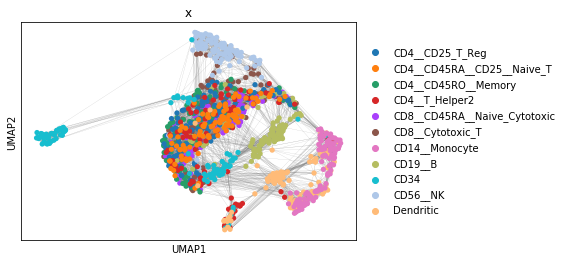

In [71]:
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='x', edges=True)

In [241]:
# sc.pp.neighbors(adata, n_neighbors=15)

In [242]:
# g_template, c_template = pollock.models.model.create_block_image_template(
#         adata, key='x', block_shape=(4, 4), size=(128, 128), nn_threshold=.05)
# g_template, c_template

In [243]:
# sorted(set(c_template.flatten()))

In [244]:
# plt.imshow(c_template=='')

## train pollock model

In [255]:
%%time

pollock_dataset = pollock.models.model.PollockDataset(adata, cell_type_key='x', dataset_type='training',
                                image_root_dir='/Users/erikstorrs/Documents/ding/pollock/models/scratch/test_zheng',
                                n_per_cell_type=100, max_val_per_cell_type=500)

2020-02-12 14:15:04,496 creating image templates
2020-02-12 14:15:32,330 setting up close groupings
2020-02-12 14:15:32,331 calculating nearest neighbors
/Users/erikstorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/pollock_v2/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
2020-02-12 14:15:49,963 calculating connectivities
2020-02-12 14:17:14,251 calculating differential genes
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of

CPU times: user 9min 58s, sys: 25.2 s, total: 10min 23s
Wall time: 8min 17s


In [256]:
x,y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 11]))

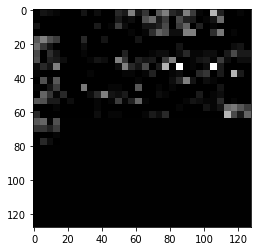

In [257]:
cell_id = adata.obs.index[0]
img = pollock_dataset.get_cell_image(cell_id)

In [259]:
pollock_dataset.cell_types, sorted(set(pollock_dataset.cell_type_template.flatten()))

(['CD14__Monocyte',
  'CD19__B',
  'CD34',
  'CD4__CD25_T_Reg',
  'CD4__CD45RA__CD25__Naive_T',
  'CD4__CD45RO__Memory',
  'CD4__T_Helper2',
  'CD56__NK',
  'CD8__CD45RA__Naive_Cytotoxic',
  'CD8__Cytotoxic_T',
  'Dendritic'],
 ['',
  'CD14__Monocyte',
  'CD14__Monocyte_diff_Dendritic',
  'CD19__B',
  'CD19__B_diff_CD4__CD45RA__CD25__Naive_T',
  'CD19__B_diff_CD4__T_Helper2',
  'CD19__B_diff_CD8__CD45RA__Naive_Cytotoxic',
  'CD34',
  'CD34_diff_CD4__T_Helper2',
  'CD4__CD25_T_Reg',
  'CD4__CD25_T_Reg_diff_CD4__CD45RA__CD25__Naive_T',
  'CD4__CD25_T_Reg_diff_CD4__CD45RO__Memory',
  'CD4__CD25_T_Reg_diff_CD4__T_Helper2',
  'CD4__CD25_T_Reg_diff_CD8__CD45RA__Naive_Cytotoxic',
  'CD4__CD25_T_Reg_diff_CD8__Cytotoxic_T',
  'CD4__CD45RA__CD25__Naive_T',
  'CD4__CD45RA__CD25__Naive_T_diff_CD4__CD45RO__Memory',
  'CD4__CD45RA__CD25__Naive_T_diff_CD4__T_Helper2',
  'CD4__CD45RA__CD25__Naive_T_diff_CD8__CD45RA__Naive_Cytotoxic',
  'CD4__CD45RA__CD25__Naive_T_diff_CD8__Cytotoxic_T',
  'CD4__CD45RO

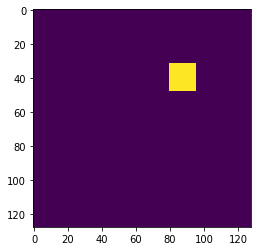

In [260]:
plt.imshow(pollock_dataset.cell_type_template=='CD4__CD45RA__CD25__Naive_T_diff_CD4__CD45RO__Memory')

In [261]:
model = PollockModel(pollock_dataset.cell_types, model=None)

In [262]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [ ]:
# base_model = tf.keras.applications.ResNet50V2(input_shape=(128, 128, 3),
#     include_top=False)
# mymodel = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(.5),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(len(model.class_names), activation='softmax')
#     ])
# mymodel.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy'])

# model.model = mymodel

In [ ]:
model.model.summary()

In [263]:
# with tf.device('/device:XLA_GPU:0'):

model.fit(pollock_dataset)

Train for 18 steps, validate for 30 steps
Epoch 1/10
18/18 [==============================] - 11s 603ms/step - loss: 1.8188 - accuracy: 0.3637 - val_loss: 1.3356 - val_accuracy: 0.5005
Epoch 2/10
18/18 [==============================] - 8s 440ms/step - loss: 1.3069 - accuracy: 0.5182 - val_loss: 1.2948 - val_accuracy: 0.5260
Epoch 3/10
18/18 [==============================] - 8s 428ms/step - loss: 1.1759 - accuracy: 0.5694 - val_loss: 1.3057 - val_accuracy: 0.5016
Epoch 4/10
18/18 [==============================] - 8s 435ms/step - loss: 1.1562 - accuracy: 0.5703 - val_loss: 1.1744 - val_accuracy: 0.5469
Epoch 5/10
18/18 [==============================] - 8s 433ms/step - loss: 0.9903 - accuracy: 0.6198 - val_loss: 1.2060 - val_accuracy: 0.5469
Epoch 6/10
18/18 [==============================] - 8s 434ms/step - loss: 1.0057 - accuracy: 0.6250 - val_loss: 1.1985 - val_accuracy: 0.5318


In [ ]:
model.save(pollock_dataset, '/home/estorrs/pollock/models/abm_3class')

In [ ]:
%%time
prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/abm_3class',
        image_root_dir = '/home/estorrs/pollock/models/scratch/test_amb_prediction')

In [ ]:
probs = model.predict(prediction_dataset)
probs.shape

In [ ]:
predictions = np.argmax(probs, axis=1).flatten()
predicted_labels = [prediction_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

In [ ]:
cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in adata[prediction_dataset.cell_ids, :].obs['Class']]
len(groundtruth), groundtruth[:5]

In [ ]:
predictions[:20], groundtruth[:20]

In [ ]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, prediction_dataset.cell_types)

In [ ]:
embedding = pollock_analysis.umap_final_layer(prediction_dataset.prediction_ds, model.model)
embedding.shape

In [ ]:
ordered_adata = adata[prediction_dataset.cell_ids, :]
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(ordered_adata, color=['predicted_cell_type', 'Class'])